# Rate of Change 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from hurst import compute_Hc
from ib_insync import *
import nest_asyncio

In [2]:
nest_asyncio.apply()

# Connect to TWS (or gateway)
ib = IB()

ib.connect('127.0.0.1', 7496, clientId=11) #7497 - Paper Trading, 7496 - Live trading

<IB connected to 127.0.0.1:7496 clientId=11>

### For IBKR Data

In [463]:
#Futures:
#contract = Future('ES', '202506', 'CME')

# Stocks:
contract = Stock('FOX', 'SMART', 'USD')

# Qualify the contract (ensures IB recognizes it)
ib.qualifyContracts(contract)

# Fetch historical data
historical_data = ib.reqHistoricalData(
    contract,
    endDateTime='',          # Leave empty for the most recent data
    durationStr='6 M',       # Look back 1 month
    barSizeSetting='5 mins',  # Daily bars
    whatToShow='TRADES',     # Show trade data (other options: MIDPOINT, BID, ASK)
    useRTH=True              # Use Regular Trading Hours (RTH) only
)

# Convert the historical data to a pandas DataFrame
df = util.df(historical_data)
df.set_index('date', inplace=True)
df.head()

,open,high,low,close,volume,average,barCount
date,,,,,,,
2024-10-14 09:30:00-04:00,38.06,38.11,37.98,38.11,4997.0,38.049,28
2024-10-14 09:35:00-04:00,38.08,38.10,38.06,38.07,1284.0,38.084,12
2024-10-14 09:40:00-04:00,38.07,38.10,38.01,38.01,5764.0,38.041,45
2024-10-14 09:45:00-04:00,38.00,38.06,38.00,38.04,3144.0,38.038,29
2024-10-14 09:50:00-04:00,38.05,38.10,38.04,38.10,5153.0,38.059,47


### Trading View Data
##### Next Cell just for Tradingview Data:

In [28]:
df1 = pd.read_csv('CL_1.csv')
df2 = pd.read_csv('CL_2.csv')
df3 = pd.read_csv('CL_3.csv')

df = pd.concat([df1, df2, df3]).drop_duplicates()

df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index, unit='s')
df.index = df.index.tz_localize('UTC')
df.index = df.index.tz_convert('US/Eastern')

In [465]:
df['date_column'] = df.index.date
df['time'] = df.index.strftime('%H:%M')
df['return'] = df['close'].pct_change()*100
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

df.head()

,open,high,low,close,volume,average,barCount,date_column,time,return,log_return
date,,,,,,,,,,,
2024-10-14 09:30:00-04:00,38.06,38.11,37.98,38.11,4997.0,38.049,28,2024-10-14,09:30,NaN,NaN
2024-10-14 09:35:00-04:00,38.08,38.10,38.06,38.07,1284.0,38.084,12,2024-10-14,09:35,-0.104959,-0.001050
2024-10-14 09:40:00-04:00,38.07,38.10,38.01,38.01,5764.0,38.041,45,2024-10-14,09:40,-0.157604,-0.001577
2024-10-14 09:45:00-04:00,38.00,38.06,38.00,38.04,3144.0,38.038,29,2024-10-14,09:45,0.078927,0.000789
2024-10-14 09:50:00-04:00,38.05,38.10,38.04,38.10,5153.0,38.059,47,2024-10-14,09:50,0.157729,0.001576


In [467]:
rows_per_day = df.groupby('date_column').size()
print("Rows per day:")
print(rows_per_day.tail(10))

Rows per day:
date_column
2025-03-31    78
2025-04-01    78
2025-04-02    78
2025-04-03    78
2025-04-04    78
2025-04-07    78
2025-04-08    78
2025-04-09    78
2025-04-10    78
2025-04-11    46
dtype: int64


# Past Return

In [469]:
df['past_return'] = (df['close'] - df['close'].shift(390)) / df['close'].shift(390)

# ROC (Rate of Change)

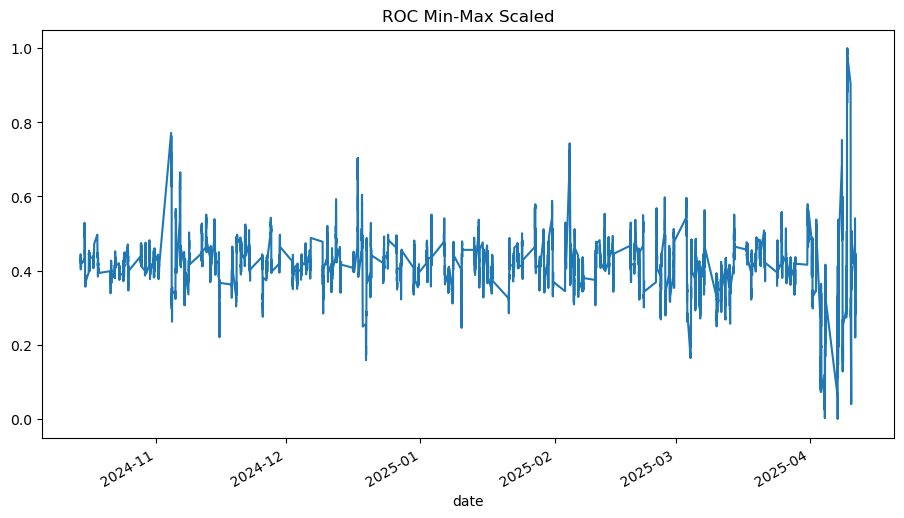

In [471]:
period = 39

df['roc'] = ((df['close'] - df['close'].shift(period)) / df['close'].shift(period)) * 100
# min max scaling
df['roc'] = (df['roc'] - df['roc'].min()) / (df['roc'].max() - df['roc'].min())

# z score of ROC
df['roc_zscore'] = (df['roc'] - df['roc'].rolling(period).mean()) / df['roc'].rolling(period).std()

df['roc'].plot(figsize=(11,6))
plt.title('ROC Min-Max Scaled')
plt.show()

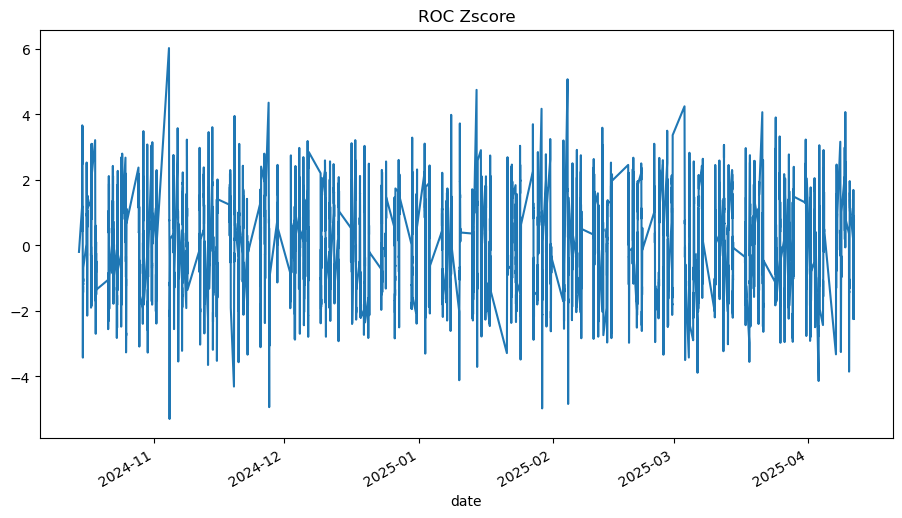

In [473]:
df['roc_zscore'].plot(figsize=(11,6))
plt.title('ROC Zscore')
plt.show()

### Past Returns

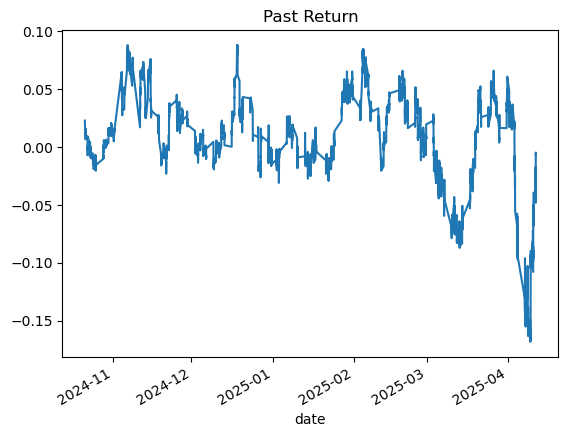

In [475]:
df['past_return'].plot()
plt.title('Past Return')
plt.show()

### Historical Volatility

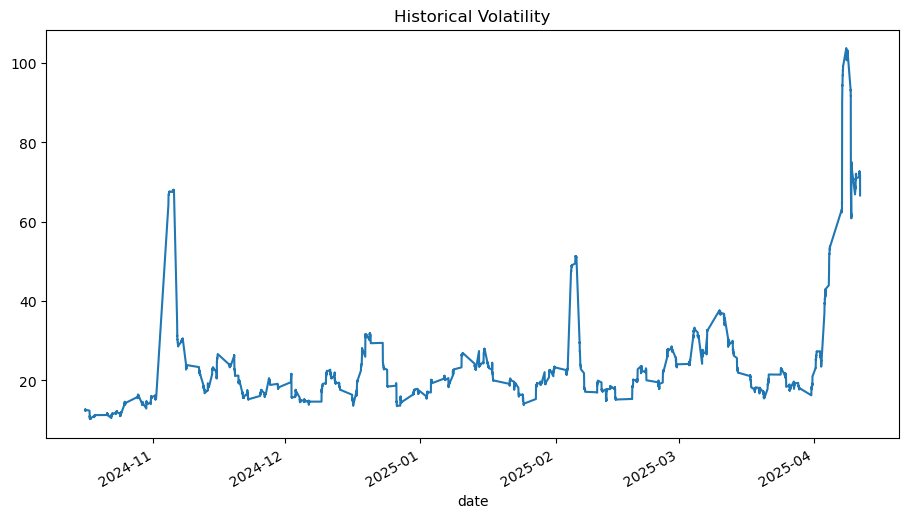

In [477]:
window = 156 #(# candles in day x  desired period)

df['historical_vol'] = (df['return'].rolling(window).std()) * np.sqrt(19656)
#df['historical_vol_zscore'] = (df['historical_vol'] - df['historical_vol'].rolling(window).mean()) / df['historical_vol'].rolling(window).std()

df['historical_vol'].plot(figsize=(11,6))
plt.title("Historical Volatility")
plt.show()

### Hurst Exponent

In [479]:
# Define rolling window size for Hurst
df.dropna(inplace=True)
window_size = 252

# Calculate Hurst exponent for each rolling window
hurst_values = []
for i in range(len(df) - window_size):
    window = df['close'][i:i + window_size]
    H, _, _ = compute_Hc(window, kind='price', simplified=True)
    hurst_values.append(H)

# Add Hurst values to the DataFrame
df['hurst'] = [np.nan] * window_size + hurst_values

### Percent of Down Candles

In [481]:
rolling_period = 156

df['down_day'] = 0
df.loc[df['return'] < 0, 'down_day'] = 1

df['percent_of_days_down'] = ((df['down_day'].rolling(rolling_period).sum())/rolling_period)*100

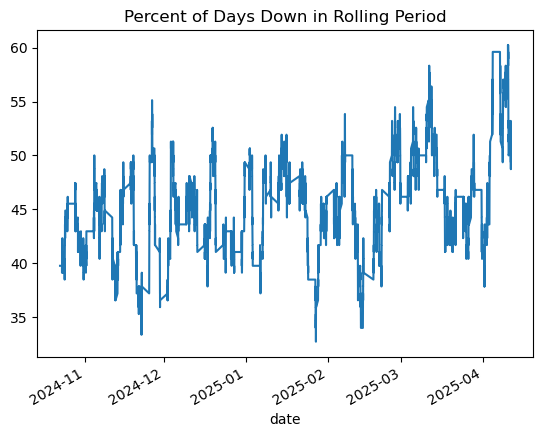

In [483]:
df['percent_of_days_down'].plot()
plt.title('Percent of Days Down in Rolling Period')
plt.show()

# Signal

In [485]:
df[['roc', 'roc_zscore', 'historical_vol', 'hurst', 'percent_of_days_down', 'past_return']].describe()

,roc,roc_zscore,historical_vol,hurst,percent_of_days_down,past_return
count,9178.000000,9178.000000,9178.000000,8926.000000,9023.000000,9178.000000
mean,0.418191,0.019238,24.772555,0.551468,45.335212,0.007706
std,0.083427,1.378978,15.044113,0.091929,4.595283,0.041368
min,0.000000,-5.306182,10.455107,0.301368,32.692308,-0.168160
25%,0.382009,-1.057579,17.387786,0.483429,42.307692,-0.009135
50%,0.417142,0.010742,20.054092,0.545090,44.871795,0.010851
75%,0.456778,1.107549,25.334177,0.615359,48.076923,0.033891
max,1.000000,6.025043,103.777805,0.817409,60.256410,0.088155


In [487]:
print('ROC Threshold (5th Percentile):',df['roc'].quantile(0.05))
print('ROC Threshold (2nd Percentile):',df['roc'].quantile(0.02))
print('PastReturn Threshold:',df['past_return'].quantile(0.05))
print('ROC ZScore Threshold:',df['roc_zscore'].quantile(0.01))

ROC Threshold (5th Percentile): 0.29518131480557913
ROC Threshold (2nd Percentile): 0.22283046989360275
PastReturn Threshold: -0.0752827028268828
ROC ZScore Threshold: -2.890640877654906


In [497]:
# thresholds for signal
roc_threshold = 0.29
past_return_threshold = -0.10
roc_zscore_threshold = -2.88

vol_threshold = 25
hurst_threshold = 0.55
percent_of_days_down_threshold = 70

# Signal Logic
df['buy_signal'] = 0

#df.loc[(df['past_return'] <= past_return_threshold) & (df['roc'] <= roc_threshold), 'buy_signal'] = 1
#df.loc[(df['past_return'] <= past_return_threshold), 'buy_signal'] = 1
df.loc[(df['roc'] <= roc_threshold) & (df['historical_vol'] <= vol_threshold), 'buy_signal'] = 1

C:\Users\eabiz\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


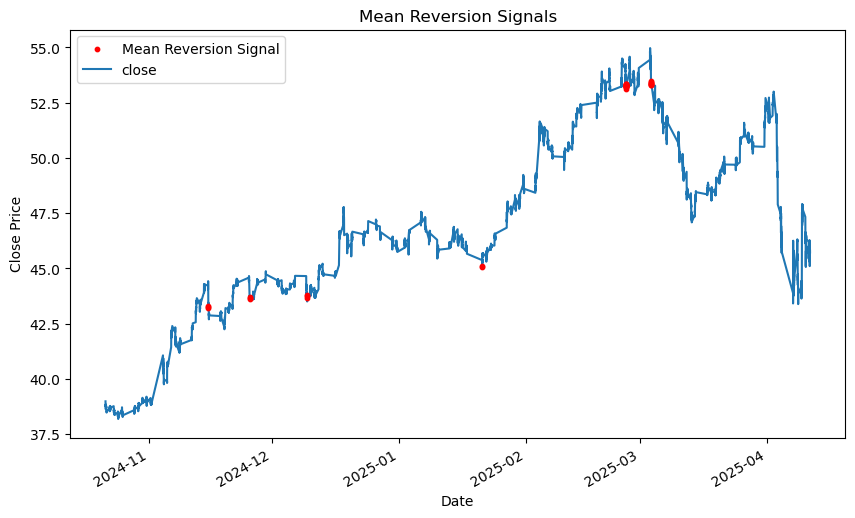

In [499]:
buy_signal = df[df['buy_signal'] == 1]

plt.scatter(buy_signal.index, buy_signal['close'], color='red', s=10, zorder=5, label='Mean Reversion Signal')
df['close'].plot(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Mean Reversion Signals')
plt.legend()
plt.show()

### Rolling Buy Signal Sum

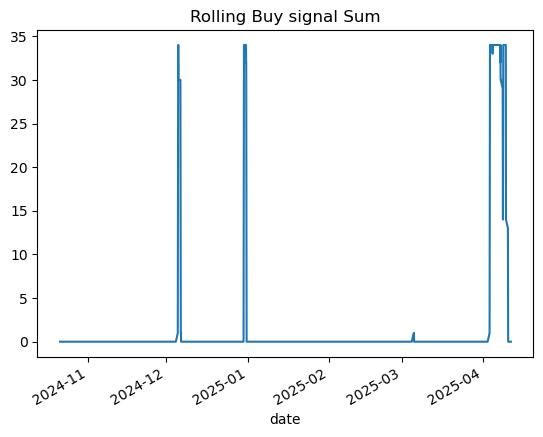

In [375]:
df['buy_signal_rolling_sum'] = df['buy_signal'].rolling(34).sum()

df['buy_signal_rolling_sum'].plot()
plt.title('Rolling Buy signal Sum')
plt.show()

C:\Users\eabiz\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


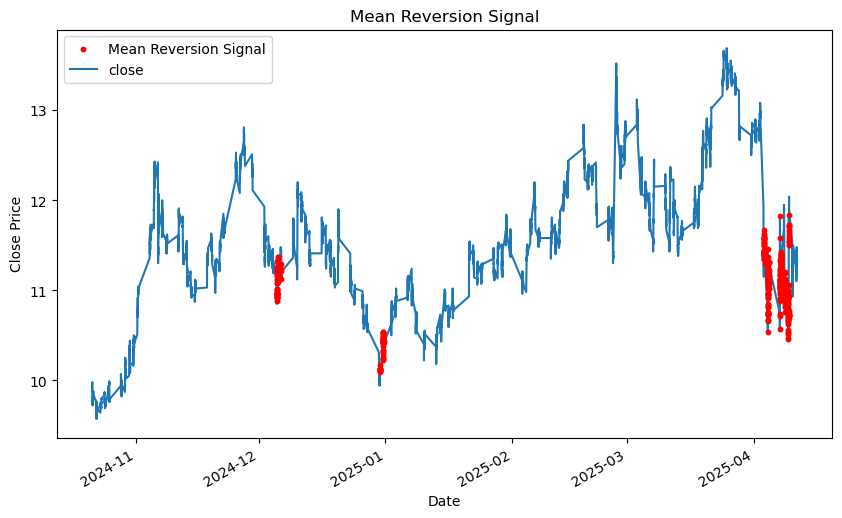

In [377]:
buy_signal_1_threshold = 30

df['buy_signal_1'] = 0 
df.loc[df['buy_signal_rolling_sum'] >= buy_signal_1_threshold, 'buy_signal_1'] = 1

buy_signal_1 = df[df['buy_signal_1'] == 1]

plt.scatter(buy_signal_1.index, buy_signal_1['close'], color='red', s=10, zorder=5, label='Mean Reversion Signal')
df['close'].plot(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Mean Reversion Signal')
plt.legend()
plt.show()

## Supress the following signals so that we don't have signal overlap

In [501]:
# Define the suppression window
window = 280

# Step 1: Identify first signals
df['buy_signal'] = df['buy_signal'] & (df['buy_signal'].shift(1, fill_value=0) == 0)

# Step 2: Suppress signals within the window after each 1
mask = df['buy_signal'].rolling(window=window + 1, min_periods=1).sum().shift(-window) > 0
df['buy_signal'] = df['buy_signal'].where(~mask, df['buy_signal'])

# Convert to integer
df['buy_signal'] = df['buy_signal'].astype(int)

C:\Users\eabiz\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


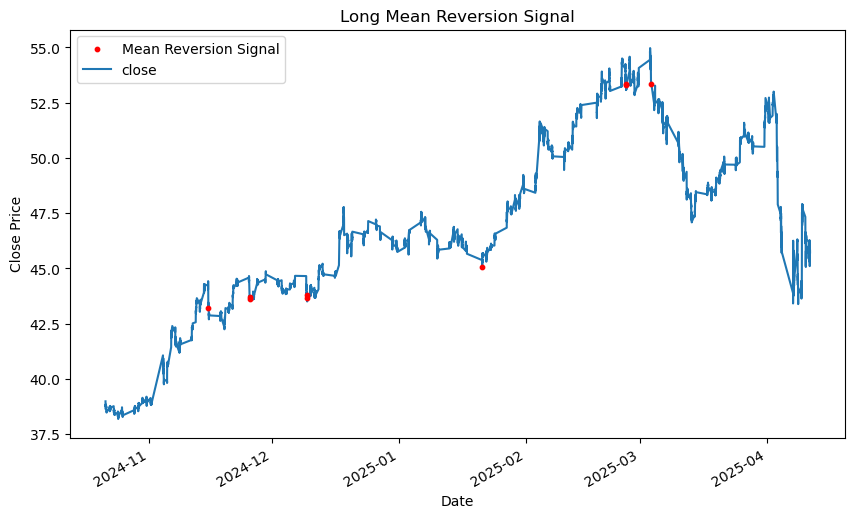

In [509]:
buy_signal = df[df['buy_signal'] == 1]

plt.scatter(buy_signal.index, buy_signal['close'], color='red', s=10, zorder=5, label='Mean Reversion Signal')
df['close'].plot(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Long Mean Reversion Signal')
plt.legend()
plt.show()

# Returns after a Signal

In [505]:
number_days_to_shift_returns = 278
df['return_after_signal'] = (df['close'].shift(-(number_days_to_shift_returns)) - df['close'])/df['close']

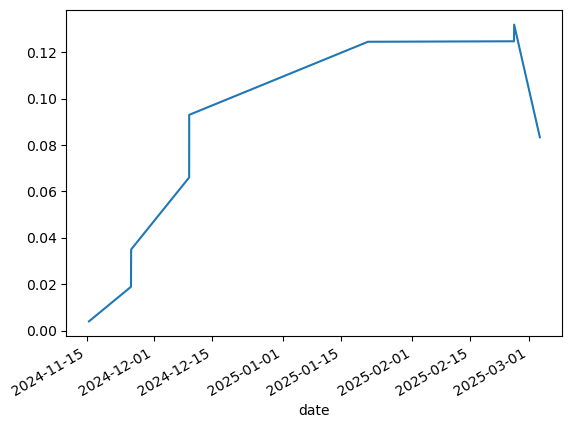

In [507]:
((df.loc[df['buy_signal'] == 1, 'return_after_signal'] + 1).cumprod() - 1).plot()
plt.show()

### Distance From MA

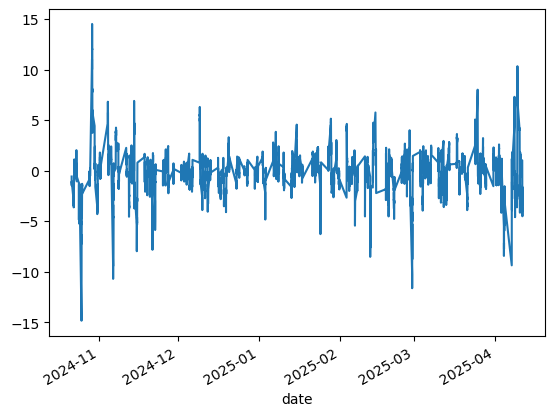

In [53]:
df['distance_from_ma'] = df['close'] - df['close'].rolling(70).mean()
df['distance_from_ma'].plot()
plt.show()

### Rolling Standard Deviation

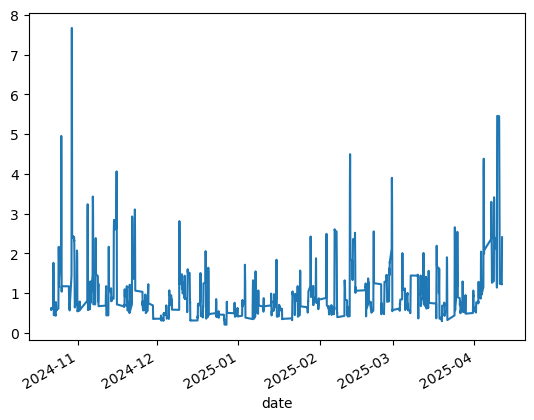

In [55]:
df['std'] = df['close'].rolling(70).std()
df['std'].plot()
plt.show()

# XGBoost

In [247]:
df.dropna(inplace=True)

### Correlation between features

In [249]:
correlation = df['distance_from_ma'].corr(df['roc'])

print('Correlation Coefficient',correlation)

Correlation Coefficient 0.39487921224277694


In [121]:
model = XGBRegressor(
    max_depth=10, #controls depth in the trees 4-10 avoids overfitting
    learning_rate=0.03,
    n_estimators=2500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'  
)

# Fit the model with an evaluation set and early stopping
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Training and test sets for evaluation
    eval_metric='rmse',                               # Metric to monitor
    early_stopping_rounds=50,                         # Stop if no improvement after 50 rounds
    verbose=True                                      # Show progress
)

NameError: name 'X_train' is not defined

In [251]:
X = df[['roc', 'std', 'historical_vol', 'hurst', 'past_return']]
y = df['return_after_signal'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    learning_rate=0.01,
    n_estimators=1500
)


# Fit the model with an evaluation set and early stopping
model.fit(X_train, y_train)

# Make predictions and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))
print()
print("Return After Signal Mean:",df['return_after_signal'].mean())

Mean Squared Error: 0.00014646545192719573
Root Mean Squared Error: 0.012102291185027557

Return After Signal Mean: -0.0003413069334973086


# XGBoost Classification

In [253]:
# Example features
X = df[['roc', 'past_return', 'hurst', 'historical_vol', 'std']]

# Example target for classification:
# If df['return_after_signal'] is continuous, convert it to binary labels.
# Here, we'll label observations above the mean as 1 and at or below as 0.
y = (df['return_after_signal'] > df['return_after_signal'].mean()).astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use XGBClassifier for classification; use an objective suitable for binary classification.
model = xgb.XGBClassifier(
    objective='binary:logistic',  # for binary classification
    random_state=42,
    learning_rate=0.1,
    n_estimators=1500     
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using classification metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9232599643069601

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       873
           1       0.92      0.92      0.92       808

    accuracy                           0.92      1681
   macro avg       0.92      0.92      0.92      1681
weighted avg       0.92      0.92      0.92      1681

Confusion Matrix:
[[808  65]
 [ 64 744]]


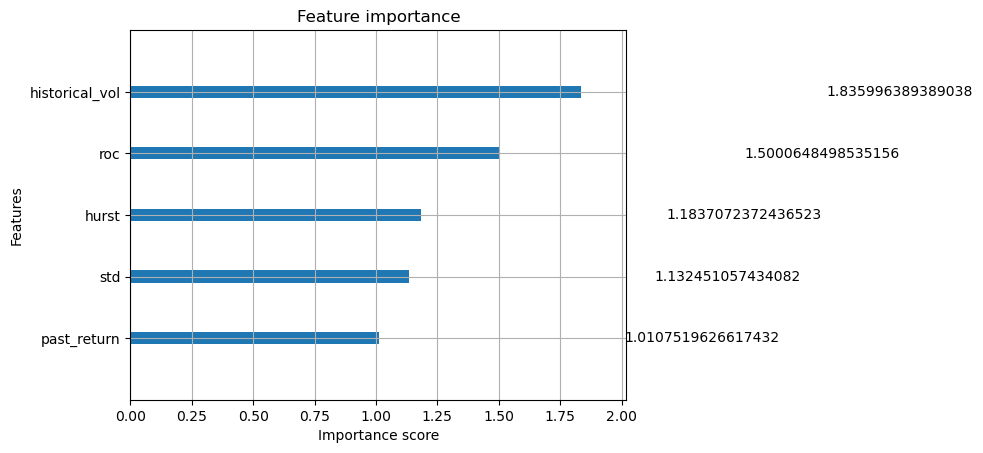

In [257]:
# Plot feature importance
from xgboost import XGBClassifier, plot_importance
plot_importance(model, importance_type='gain', max_num_features=10)
plt.show()

In [795]:
df.tail()

,open,high,low,close,MA,date,time,return,log_return,past_return,roc,roc_zscore,historical_vol,hurst,down_day,percent_of_days_down,buy_signal,return_after_signal,distance_from_ma,std
time,,,,,,,,,,,,,,,,,,,,
2025-03-26 16:00:00-04:00,69.72,69.82,69.72,69.81,67.51780,2025-03-26,16:00,0.143451,0.001433,0.041629,0.667257,1.496051,17.201017,0.467697,0,50.000000,0,-0.106432,0.999286,0.707816
2025-03-27 09:30:00-04:00,69.58,69.62,69.12,69.57,67.53435,2025-03-27,09:30,-0.343790,-0.003444,0.040688,0.664800,1.407825,17.296343,0.469527,1,53.571429,0,-0.148627,0.720429,0.672392
2025-03-27 10:00:00-04:00,69.58,69.78,69.36,69.76,67.55240,2025-03-27,10:00,0.273106,0.002727,0.032717,0.643995,0.487165,15.843639,0.448035,0,50.000000,0,-0.143349,0.878857,0.662296
2025-03-27 10:30:00-04:00,69.77,69.96,69.73,69.91,67.57195,2025-03-27,10:30,0.215023,0.002148,0.029602,0.635868,0.099503,15.525071,0.444880,0,46.428571,0,-0.147761,1.000143,0.662714
2025-03-27 11:00:00-04:00,69.90,69.97,69.81,69.86,67.59090,2025-03-27,11:00,-0.071521,-0.000715,0.024490,0.622526,-0.518359,15.294557,0.444293,1,46.428571,0,-0.147008,0.926286,0.666473


# Linear Regression

In [129]:
# OLS Linear regression
X = df[['roc','roc_zscore','distance_from_ma', 'std', 'historical_vol','hurst', 'percent_of_days_down', 'past_return']]
y = df['return_after_signal']
model = sm.OLS(y, X).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     return_after_signal   R-squared:                       0.130
Model:                             OLS   Adj. R-squared:                  0.127
Method:                  Least Squares   F-statistic:                     54.17
Date:                 Thu, 10 Apr 2025   Prob (F-statistic):           1.90e-72
Time:                         19:37:34   Log-Likelihood:                 2786.1
No. Observations:                 2555   AIC:                            -5556.
Df Residuals:                     2547   BIC:                            -5509.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
roc                   

# K-Means Clustering

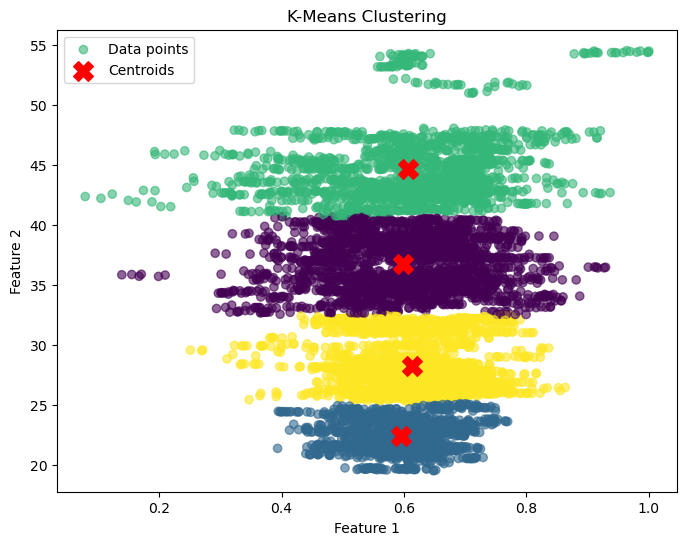

In [357]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Suppose df has two features for visualization: 'feature1' and 'feature2'
X = df[['roc', 'historical_vol']]

# Run K-Means with 3 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

# Retrieve the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plot the clustered data
plt.figure(figsize=(8, 6))
plt.scatter(X['roc'], X['historical_vol'], c=labels, cmap='viridis', alpha=0.6, label='Data points')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering')
plt.legend()
plt.show()
